### Imports

In [184]:
import numpy as np
import pandas as pd
import ace_tools_open as tools
from case_studies import *
import time
import matplotlib.pyplot as plt

In [185]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f3, f4, f5]
dfs = [df1, df3, df4, df5]
Hfs = [Hf1, Hf3, Hf4, Hf5]
fnames = ["f1", "f3", "f4", "f5"]

In [186]:
def backtracking_line_search(f, df, x, pk, alpha_init, c1, rho):
    alpha = alpha_init
    while f(x + alpha * pk) > f(x) + c1 * alpha * np.dot(df(x), pk):
        alpha *= rho
        
    return alpha

### Newtons Method

In [187]:
def newtons_method_constrained(f, df, Hf, x0, A, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    x = x0
    xs = [x0]
    projected_grad_norms = []

    AAT_inv = np.linalg.inv(np.dot(A, A.T))
    
    last_term = np.dot(A.T, np.dot(AAT_inv, A))
    
    I = np.eye(last_term.shape[0], last_term.shape[1])
    
    M = I - last_term
    
    for _ in range(max_iters):
        grad = df(x) #(n,)
        hessian = Hf(x) #(n,n)
        
        if np.all(np.linalg.eigvals(hessian) > 0):
            B = hessian
        else:
            eigvals, eigvecs = np.linalg.eigh(hessian)
            B = sum(np.abs(eigval) * np.outer(eigvec, eigvec) for eigval, eigvec in zip(eigvals, eigvecs.T))
        
        #Prepare linear system of equations
        m, n = A.shape
        top = np.hstack([B, A.T])
        bottom = np.hstack([A, np.zeros([m, m])])
        lhs_matrix = np.vstack([top, bottom])
        rhs = np.vstack([-grad.reshape(-1, 1), np.zeros([m, 1])]) #(n, 1), (m, 1)

        #Solve linear system to get search direction vec and lambdas
        solution = np.linalg.solve(lhs_matrix, rhs) #(n+m, 1), p in R^n and lambda in R^m
        p = solution[:n].flatten() #(n,)
        
        #Find step size
        alpha = backtracking_line_search(f, df, x, p, 1.0, c1, rho)
        x = x + alpha * p #
        xs.append(x)
        projected_grad_norm = np.linalg.norm(np.dot(M, grad))
        projected_grad_norms.append(projected_grad_norm)
        #print(f"Stopping condition: {np.linalg.norm(np.dot(M, grad))}, {f.__name__}")
        if projected_grad_norm < tol:
            break
        
    return x, xs, projected_grad_norms

### Steepest Descent

In [188]:
def steepest_descent_constrained(f, df, x0, A, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    x = x0
    xs = [x0]
    projected_grad_norms = []
    beta = 1
    
    AAT_inv = np.linalg.inv(np.dot(A, A.T))
    
    last_term = np.dot(A.T, np.dot(AAT_inv, A))
    
    I = np.eye(last_term.shape[0], last_term.shape[1])
    
    M = I - last_term

    for _ in range(max_iters):
        grad = df(x)
        p = np.dot(-M, grad)
        alpha = backtracking_line_search(f, df, x, p, beta, c1, rho)
        x = x + alpha * p
        beta = alpha / rho
        xs.append(x)
        projected_grad_norm = np.linalg.norm(np.dot(M, grad))
        projected_grad_norms.append(projected_grad_norm)
        #print(f"Stopping condition: {np.linalg.norm(np.dot(M, grad))}, {f.__name__}")
        if projected_grad_norm < tol:
            break

    return x, xs, projected_grad_norms


In [ ]:
def generate_constraint(m, n, fname):
    A = np.random.randn(m, n)
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    print(S)
    S = np.linspace(0.1, 2, m)
    print(S)
    print(np.diag(S))
    A = U @ np.diag(S) @ Vt #take np.diag because of shapes

    x_unconstrained_optimum = x_opt(fname, n)
    offset = np.random.randn(n)
    b = - A @ (x_unconstrained_optimum + offset)

    x = np.linalg.lstsq(A, -b, rcond=None)[0]

    return A, b, x

# Example Usage:
A, b, x = generate_constraint(4, 5, "f4")
print("A:", A, "\n")
print("b:", b, "\n")
print("x:", x)
# print(A @ x)

[3.07368187 1.71939197 1.02632382 0.14157098]
[0.1        0.73333333 1.36666667 2.        ]
[[0.1        0.         0.         0.        ]
 [0.         0.73333333 0.         0.        ]
 [0.         0.         1.36666667 0.        ]
 [0.         0.         0.         2.        ]]
A: [[-0.01352434  1.09400495 -0.5277417   0.43391785 -0.68182134]
 [ 0.71201205  0.09983176 -0.30159105  0.85305415 -0.63334603]
 [ 0.87357161 -0.26775091  0.46089431  0.70984314 -0.78206527]
 [-0.05009307  0.20084501  0.36317811 -0.28376255 -0.36348838]] 

b: [2.83675764 1.87883404 1.30215627 0.37292576] 

x: [-0.22026807 -1.41707319  0.17426338 -0.92364381  1.16848785]


In [190]:
def benchmark(f, df, optimizer, x0, A, x_opt, Hf=None):
    start_time = time.time()
    if optimizer == newtons_method_constrained:
        x_final, xs, projected_grad_norms = optimizer(f, df, Hf, x0, A)
    if optimizer == steepest_descent_constrained:
        x_final, xs, projected_grad_norms = optimizer(f, df, x0, A)
    end_time = time.time()

    num_iterations = len(xs)-1
    final_solution_point = x_final
    dist_to_optimum = np.linalg.norm(x_final-x_opt)
    final_fun_value = f(xs[-1])
    duration = end_time-start_time

    return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, projected_grad_norms, projected_grad_norms[-1])


In [191]:
SEED = 10
np.random.seed(SEED)
d = 20
m = 5
num_runs = 100
benchmark_results = []

for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(f, d)

    #Newtons Method constrained
    for _ in range(num_runs):
        
        A, _, x0 = generate_constraint(m, d, fname)

        nm_result = benchmark(f, df, newtons_method_constrained, x0, A, x_optimal, Hf)
        benchmark_results.append((fname, "Newtons Method Constrained") + nm_result)

        #Steepest Descent
        sd_result = benchmark(f, df, steepest_descent_constrained, x0, A, x_optimal)
        benchmark_results.append((fname, "Steepest Descent Constrained") + sd_result)
        
#Organize in dataframe
columns = ["Function", "Optimizer", "Iterations", "Time", "Final Function Value", "Final Solution Point", "Distance to Optimum", "Projected Gradient Norms", "Final Projected Gradient Norm"]
df_results = pd.DataFrame(benchmark_results, columns=columns)

df_display = df_results.drop(columns=["Final Solution Point", "Projected Gradient Norms"])
tools.display_dataframe_to_user(name="Benchmark Results", dataframe=df_display)

[6.47785668 4.570581   4.03170527 3.08168111 2.35435597]
[0.1   0.575 1.05  1.525 2.   ]
[[0.1   0.    0.    0.    0.   ]
 [0.    0.575 0.    0.    0.   ]
 [0.    0.    1.05  0.    0.   ]
 [0.    0.    0.    1.525 0.   ]
 [0.    0.    0.    0.    2.   ]]
[6.51992691 5.25323664 4.28930597 2.89572779 2.10892574]
[0.1   0.575 1.05  1.525 2.   ]
[[0.1   0.    0.    0.    0.   ]
 [0.    0.575 0.    0.    0.   ]
 [0.    0.    1.05  0.    0.   ]
 [0.    0.    0.    1.525 0.   ]
 [0.    0.    0.    0.    2.   ]]
[5.30038197 4.85077247 4.75393842 4.16839334 2.77379227]
[0.1   0.575 1.05  1.525 2.   ]
[[0.1   0.    0.    0.    0.   ]
 [0.    0.575 0.    0.    0.   ]
 [0.    0.    1.05  0.    0.   ]
 [0.    0.    0.    1.525 0.   ]
 [0.    0.    0.    0.    2.   ]]
[5.09956502 4.82762451 3.39394259 3.10985713 1.85258931]
[0.1   0.575 1.05  1.525 2.   ]
[[0.1   0.    0.    0.    0.   ]
 [0.    0.575 0.    0.    0.   ]
 [0.    0.    1.05  0.    0.   ]
 [0.    0.    0.    1.525 0.   ]
 [0.    0.    

In [192]:
df_avg_results = df_results.groupby(["Function", "Optimizer"]).agg({
    "Iterations": "mean",
    "Time": "mean",
    "Final Function Value": "mean",
    "Distance to Optimum": "mean",
    "Final Projected Gradient Norm": "mean"
}).reset_index()

# Display the final averaged results
tools.display_dataframe_to_user(name="Averaged Optimization Results", dataframe=df_avg_results)

Averaged Optimization Results


In [193]:
def extract_grad_norms(df, function_name, optimizer_name):
    return df[(df["Function"] == function_name) &  (df["Optimizer"] == optimizer_name)]["Projected Gradient Norms"].tolist()


def pad_grad_norms(grad_norms_list):
    max_length_run = max(len(run) for run in grad_norms_list)
    #print(max_length_run)
    padded_runs = []

    for run in grad_norms_list:
        padded_run = np.pad(run, (0, max_length_run - len(run)), mode="constant", constant_values=0)
        padded_runs.append(padded_run)
    
    return padded_runs

def get_avg_grad_norms(df, function_name, optimizer_name):

    grad_norms = extract_grad_norms(df, function_name, optimizer_name)
    padded_grad_norms = pad_grad_norms(grad_norms)
    mean_grad_norms = np.mean(padded_grad_norms, axis=0)

    return mean_grad_norms

In [194]:
f1_newton_avg = get_avg_grad_norms(df_results, "f1", "Newtons Method Constrained")
f3_newton_avg = get_avg_grad_norms(df_results, "f3", "Newtons Method Constrained")
f4_newton_avg = get_avg_grad_norms(df_results, "f4", "Newtons Method Constrained")
f5_newton_avg = get_avg_grad_norms(df_results, "f5", "Newtons Method Constrained")

f1_sd_avg = get_avg_grad_norms(df_results, "f1", "Steepest Descent Constrained")
f3_sd_avg = get_avg_grad_norms(df_results, "f3", "Steepest Descent Constrained")
f4_sd_avg = get_avg_grad_norms(df_results, "f4", "Steepest Descent Constrained")
f5_sd_avg = get_avg_grad_norms(df_results, "f5", "Steepest Descent Constrained")

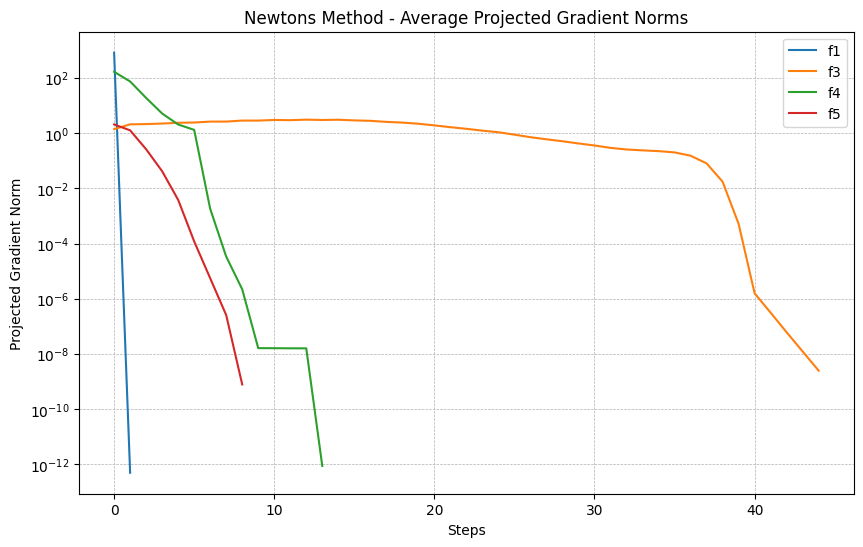

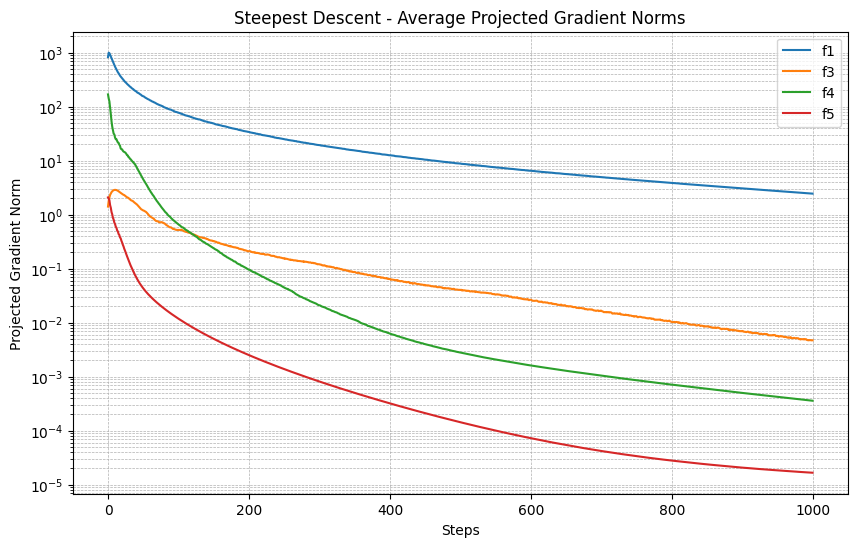

In [195]:
def plot_convergence(title, f1_avg, f3_avg, f4_avg, f5_avg):
    plt.figure(figsize=(10, 6))

    plt.plot(range(len(f1_avg)), f1_avg, label="f1")
    plt.plot(range(len(f3_avg)), f3_avg, label="f3")
    plt.plot(range(len(f4_avg)), f4_avg, label="f4")
    plt.plot(range(len(f5_avg)), f5_avg, label="f5")

    plt.xlabel("Steps")
    plt.ylabel("Projected Gradient Norm")
    plt.title(title)
    plt.yscale("log")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

plot_convergence("Newtons Method - Average Projected Gradient Norms", f1_newton_avg, f3_newton_avg, f4_newton_avg, f5_newton_avg)
plot_convergence("Steepest Descent - Average Projected Gradient Norms", f1_sd_avg, f3_sd_avg, f4_sd_avg, f5_sd_avg)
